In [1]:
import requests
import re

In [2]:
shakespeare = {
    'romeo':{
        'url':'https://www.gutenberg.org/files/1513/1513-0.txt',
        'path': 'data/romeo.txt',
        'node_color': '#ca9ae1',
        'title': 'Romeo & Juliet'
    },
    'othello':{
        'url':'https://www.gutenberg.org/files/1531/1531-0.txt',
        'path': 'data/othello.txt',
        'node_color':'#9999ff',
        'title': 'Othello, the Moor of Venice'
    },
    'hamlet':{
        'url':'https://www.gutenberg.org/files/1524/1524-0.txt',
        'path': 'data/hamlet.txt',
        'node_color': '#ffbc66',
        'title': 'Hamlet'
    },
    'macbeth':{
        'url': 'https://www.gutenberg.org/files/1533/1533-0.txt',
        'path': 'data/macbeth.txt',
        'node_color': '#FF9999',
        'title': 'Macbeth'
    },
    'midsummer':{
        'url': 'https://www.gutenberg.org/files/1514/1514-0.txt',
        'path': 'data/midsummer.txt',
        'node_color': '#e1a79a',
        'title': 'A Midsummer Night’s Dream'
    },
    'caesar':{
        'url': 'https://www.gutenberg.org/files/1522/1522-0.txt',
        'path': 'data/caesar.txt',
        'node_color': '#9AB1E1',
        'title': 'Julius Caesar'
    }
}

In [3]:
THIS_PLAY = 'caesar'

# Get contents of text file

In [4]:
this_file = open(shakespeare[THIS_PLAY]['path'], "r")
data = this_file.read()
this_file.close() 

# Extract acts

In [5]:
_, body, _ = re.split(r'\*{3}[^\*]+THIS PROJECT GUTENBERG EBOOK[^\*]+\*{3}', data) # find body of text, discard header & footer

assert len(body) >= 0.8*len(data), 'Verify split of body, header, & footer. May have bad split.'

In [6]:
_, body = re.split(r'\bDramatis\sPerson.', body) # find body of text, discard table of contents
# _, body = re.split(r'\bDramatis\sPerson.|\bDRAMATIS\sPERSON.', body) # find body of text, discard table of contents

characters, *acts = re.split(r'\b(ACT\s\w+)', body) # capture initial list of characters & all the acts

assert sum([len(i) for i in acts]) >= 0.95*len(body), 'Verify split of acts. May have bad split.'

# Create dictionary

In [7]:
these_acts = []
these_bodies = []
while acts:
  this_item = acts.pop(0)
  if len(this_item)<100:
    these_acts.append(this_item)
  else:
    these_bodies.append(this_item)

assert not acts, 'Check acts var. Still contains content.'
assert (len(these_acts)==5) and (len(these_bodies)==5), 'Verify lists generation. Play should have five acts.'

In [8]:
acts_dict = dict(zip(these_acts,these_bodies))

assert sum([len(v) for k,v in acts_dict.items()]) >= 0.97*len(body), 'Verify generation of dictionary content. May have lost content somewhere.'

In [9]:
acts_scenes = {}
for i in acts_dict.keys():
  this_act = acts_dict[i]

  found = re.findall(r'\b([A-Z]+\s?[A-Z]+?)\b', this_act)
  # found = re.findall(r'\b([A-Z]+\s?[A-Z]+?)\b|(\bScene\s\w+)\b', this_act)

  # scene_indices = [i for i, e in enumerate(found) if e.startswith('SCENE')]
  scene_indices = [i for i, e in enumerate(found) if ((e.startswith('SCENE')) or (e.startswith('Scene')))]
  scene_indices.append(len(found))

  these_scenes = []
  these_bodies = []
  for j in scene_indices:
    try:
      these_chars = found[j:scene_indices[scene_indices.index(j)+1]]
      this_scene = these_chars.pop(0)

      these_scenes.append(this_scene)
      these_bodies.append(these_chars)
    except:
      pass

  scenes_dict = dict(zip(these_scenes, these_bodies))
  acts_scenes[i] = scenes_dict

  print(i, list(scenes_dict.keys()))

ACT I ['SCENE I', 'SCENE II', 'SCENE III']
ACT II ['SCENE I', 'SCENE II', 'SCENE III', 'SCENE IV']
ACT III ['SCENE I', 'SCENE II', 'SCENE III']
ACT IV ['SCENE I', 'SCENE II', 'SCENE III']
ACT V ['SCENE I', 'SCENE II', 'SCENE III', 'SCENE IV', 'SCENE V']


# Create network

In [10]:
import networkx as nx

In [11]:
G = nx.Graph()

In [12]:
for act in acts_scenes.values():
  for characters in act.values():
    for i in range(len(characters)):
      try:
        if G.has_edge(characters[i],characters[i+1]):
          G.edges()[characters[i],characters[i+1]]['weight']+=1
        else:
          G.add_edge(characters[i], characters[i+1], weight=1)
      except:
        pass

In [13]:
from collections import Counter

In [14]:
char_count = []
for act in acts_scenes.values():
  for characters in act.values():
    for i in characters:
      char_count.append(i)

character_counter = Counter(char_count)

nx.set_node_attributes(G, character_counter, name='presence')

# Create plot of network

In [15]:
import matplotlib.pyplot as plt

In [16]:
all_components = [list(i) for i in sorted(nx.connected_components(G), key=len, reverse=True)]
print(f'There are {len(all_components)} total components in the play.')

There are 2 total components in the play.


In [17]:
G = nx.subgraph(G, all_components[0]) # find LCC & set as graph

sum_weights = sum([i[2]['weight'] for i in G.edges(data=True)])
node_list = [node for node in G.nodes()]
node_size = [node[1]['presence']*25 for node in G.nodes(data=True)] # FIND BETTER WAY TO NORMALIZE

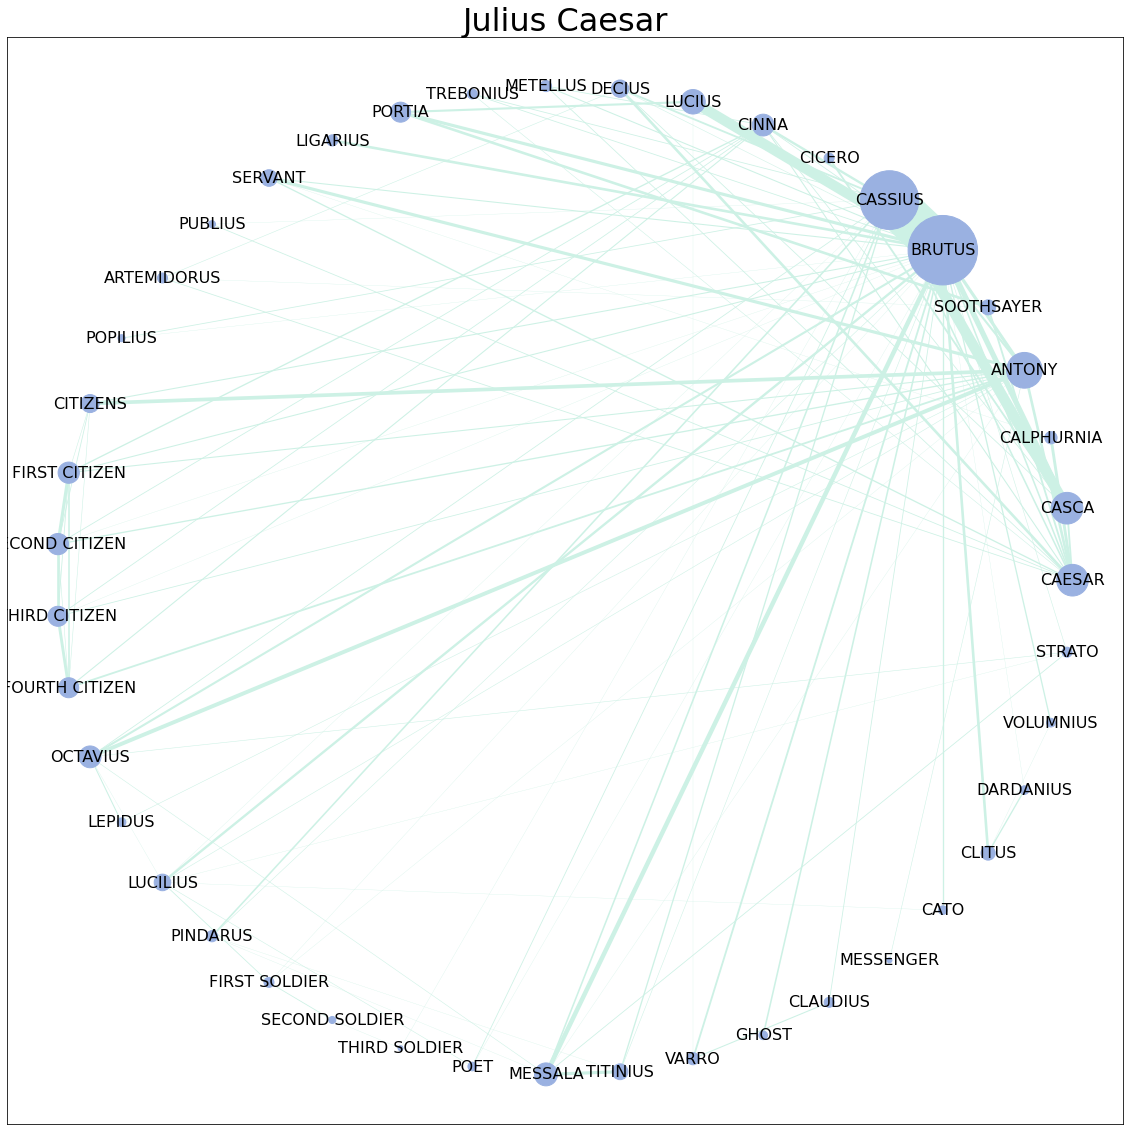

In [18]:
plt.figure(figsize=(20,20))
plt.gca().set_facecolor('white')

pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_size=node_size, node_color=shakespeare[THIS_PLAY]['node_color'], label=True)
nx.draw_networkx_labels(G, pos, dict(zip(node_list,node_list)), font_size=16, font_color='black')

for edge in G.edges(data='weight'):
  this_weight = (edge[2]/sum_weights)*200 # FIND BETTER WAY TO NORMALIZE
  nx.draw_networkx_edges(G, pos, edgelist=[edge], width=this_weight, edge_color='#CDF1E5') # darker edge_color='#C1EDDF'

plt.title(shakespeare[THIS_PLAY]['title'], fontdict={'fontsize':32});

# Calculate centrality measures

In [19]:
between_dict = nx.betweenness_centrality(G)
sorted(between_dict, key=between_dict.get, reverse=True)

['BRUTUS',
 'ANTONY',
 'CASSIUS',
 'CAESAR',
 'CASCA',
 'FIRST SOLDIER',
 'CINNA',
 'OCTAVIUS',
 'SERVANT',
 'DECIUS',
 'LUCILIUS',
 'PORTIA',
 'THIRD SOLDIER',
 'MESSALA',
 'FIRST CITIZEN',
 'SECOND CITIZEN',
 'THIRD CITIZEN',
 'CITIZENS',
 'SOOTHSAYER',
 'SECOND SOLDIER',
 'FOURTH CITIZEN',
 'LUCIUS',
 'ARTEMIDORUS',
 'VARRO',
 'CLITUS',
 'STRATO',
 'CALPHURNIA',
 'CICERO',
 'METELLUS',
 'TREBONIUS',
 'LIGARIUS',
 'PUBLIUS',
 'POPILIUS',
 'LEPIDUS',
 'PINDARUS',
 'POET',
 'TITINIUS',
 'GHOST',
 'CLAUDIUS',
 'MESSENGER',
 'CATO',
 'DARDANIUS',
 'VOLUMNIUS']

In [20]:
close_dict = nx.closeness_centrality(G)
sorted(close_dict, key=close_dict.get, reverse=True)

['BRUTUS',
 'CASSIUS',
 'ANTONY',
 'CAESAR',
 'CINNA',
 'LUCILIUS',
 'CASCA',
 'OCTAVIUS',
 'MESSALA',
 'DECIUS',
 'SERVANT',
 'FIRST CITIZEN',
 'SECOND CITIZEN',
 'THIRD CITIZEN',
 'FIRST SOLDIER',
 'METELLUS',
 'TREBONIUS',
 'CITIZENS',
 'PINDARUS',
 'TITINIUS',
 'PORTIA',
 'POET',
 'STRATO',
 'LUCIUS',
 'POPILIUS',
 'VARRO',
 'CLITUS',
 'CLAUDIUS',
 'CATO',
 'DARDANIUS',
 'VOLUMNIUS',
 'LIGARIUS',
 'GHOST',
 'FOURTH CITIZEN',
 'PUBLIUS',
 'THIRD SOLDIER',
 'SOOTHSAYER',
 'LEPIDUS',
 'ARTEMIDORUS',
 'MESSENGER',
 'CALPHURNIA',
 'CICERO',
 'SECOND SOLDIER']

In [21]:
info_dict = nx.information_centrality(G)
sorted(info_dict, key=info_dict.get, reverse=True)

['BRUTUS',
 'CASSIUS',
 'ANTONY',
 'CAESAR',
 'CINNA',
 'LUCILIUS',
 'MESSALA',
 'OCTAVIUS',
 'SECOND CITIZEN',
 'FIRST CITIZEN',
 'THIRD CITIZEN',
 'CASCA',
 'FOURTH CITIZEN',
 'DECIUS',
 'CITIZENS',
 'STRATO',
 'TITINIUS',
 'PINDARUS',
 'SERVANT',
 'FIRST SOLDIER',
 'TREBONIUS',
 'POET',
 'METELLUS',
 'PORTIA',
 'ARTEMIDORUS',
 'LUCIUS',
 'SOOTHSAYER',
 'VARRO',
 'CLITUS',
 'POPILIUS',
 'PUBLIUS',
 'CATO',
 'LEPIDUS',
 'CALPHURNIA',
 'CLAUDIUS',
 'DARDANIUS',
 'VOLUMNIUS',
 'THIRD SOLDIER',
 'SECOND SOLDIER',
 'GHOST',
 'LIGARIUS',
 'MESSENGER',
 'CICERO']

In [22]:
page_dict = nx.pagerank(G)
sorted(page_dict, key=page_dict.get, reverse=True)

['BRUTUS',
 'CASSIUS',
 'ANTONY',
 'CAESAR',
 'CASCA',
 'LUCIUS',
 'MESSALA',
 'OCTAVIUS',
 'SECOND CITIZEN',
 'CINNA',
 'FIRST CITIZEN',
 'FOURTH CITIZEN',
 'THIRD CITIZEN',
 'PORTIA',
 'LUCILIUS',
 'CITIZENS',
 'DECIUS',
 'SERVANT',
 'CLITUS',
 'SOOTHSAYER',
 'TITINIUS',
 'FIRST SOLDIER',
 'VARRO',
 'CALPHURNIA',
 'SECOND SOLDIER',
 'METELLUS',
 'PINDARUS',
 'LIGARIUS',
 'CLAUDIUS',
 'STRATO',
 'DARDANIUS',
 'TREBONIUS',
 'ARTEMIDORUS',
 'LEPIDUS',
 'POET',
 'CICERO',
 'VOLUMNIUS',
 'CATO',
 'GHOST',
 'THIRD SOLDIER',
 'PUBLIUS',
 'POPILIUS',
 'MESSENGER']

In [23]:
cluster_dict = nx.clustering(G)
sorted(cluster_dict, key=cluster_dict.get, reverse=True)

['CALPHURNIA',
 'METELLUS',
 'TREBONIUS',
 'PUBLIUS',
 'POPILIUS',
 'LEPIDUS',
 'PINDARUS',
 'POET',
 'TITINIUS',
 'CLAUDIUS',
 'CATO',
 'DARDANIUS',
 'VOLUMNIUS',
 'CITIZENS',
 'THIRD CITIZEN',
 'STRATO',
 'FIRST CITIZEN',
 'SECOND CITIZEN',
 'FOURTH CITIZEN',
 'DECIUS',
 'LUCIUS',
 'SERVANT',
 'ARTEMIDORUS',
 'VARRO',
 'CLITUS',
 'OCTAVIUS',
 'MESSALA',
 'CASCA',
 'FIRST SOLDIER',
 'CINNA',
 'LUCILIUS',
 'SOOTHSAYER',
 'PORTIA',
 'ANTONY',
 'CAESAR',
 'CASSIUS',
 'BRUTUS',
 'CICERO',
 'LIGARIUS',
 'SECOND SOLDIER',
 'THIRD SOLDIER',
 'GHOST',
 'MESSENGER']

# END